<a href="https://colab.research.google.com/github/wayoo2019/Summer-Projects/blob/master/WF_fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# mount Google Drive to import data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#models
import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit, train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix

import time
import warnings
import gc


import datetime

pd.set_option('display.max_columns', None)
# plt.style.use(style = 'seaborn')

warnings.filterwarnings('ignore')

In [4]:
%%time
train = pd.read_excel("/content/drive/MyDrive/WellsFargo competition/train.xlsx")
test = pd.read_excel("/content/drive/MyDrive/WellsFargo competition/test.xlsx")

CPU times: user 4.29 s, sys: 14.9 ms, total: 4.31 s
Wall time: 5.11 s


In [47]:
del train, test

In [5]:
# encode accordingly
train['FRAUD_NONFRAUD'] = train['FRAUD_NONFRAUD'].map({'Fraud': 0, 'Non-Fraud': 1})

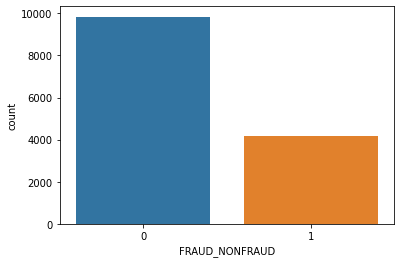

In [ ]:
sns.countplot(x="FRAUD_NONFRAUD", data=train)

In [6]:
train['FRAUD_NONFRAUD'].mean()

0.7025714285714286

## 1. Feature Validation

In [ ]:
# check difference between train and test columns name

print("Train column num is: ", len(train.columns))
print("Test column num is: ", len(test.columns))

train.columns.difference(test.columns), test.columns.difference(train.columns)

Train column num is:  24
Test column num is:  24


(Index(['FRAUD_NONFRAUD'], dtype='object'),
 Index(['dataset_id'], dtype='object'))

Remove low infomation columns

In [ ]:
# Features with only 1 unique value
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

# Features with more than 90% missing values
many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9]

# Features with the top value appears more than 90% of the time
big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + big_top_value_cols_test + one_value_cols + one_value_cols_test))
# cols_to_drop.remove("FRAUD_NONFRAUD")

print('{} features are going to be dropped for being useless'.format(len(cols_to_drop)))
print(cols_to_drop)

4 features are going to be dropped for being useless
['AUTHC_SCNDRY_STAT_TXT', 'ACTN_INTNL_TXT', 'TRAN_TYPE_CD', 'ACTN_CD']


In [ ]:
# remove columns 
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [ ]:
# Define Covariate shift function for train and test verification
def covariate_shift(feature):
    df_card1_train = pd.DataFrame(data={feature: train[feature], 'isTest': 0})
    df_card1_test = pd.DataFrame(data={feature: test[feature], 'isTest': 1})

    # Creating a single dataframe
    df = pd.concat([df_card1_train, df_card1_test], ignore_index=True)
    
    # Encoding if feature is categorical
    if str(df[feature].dtype) in ['object', 'category']:
        df[feature] = LabelEncoder().fit_transform(df[feature].astype(str))
    
    # Splitting it to a training and testing set
    X_train, X_test, y_train, y_test = train_test_split(df[feature], df['isTest'], test_size=0.33, random_state=47, stratify=df['isTest'])

    clf = lgb.LGBMClassifier()
    clf.fit(X_train.values.reshape(-1, 1), y_train)
    roc_auc =  roc_auc_score(y_test, clf.predict_proba(X_test.values.reshape(-1, 1))[:, 1])

    del df, X_train, y_train, X_test, y_test
    gc.collect();
    
    return roc_auc

In [ ]:
def df_covariate_shift(col_list, df):
  temp = pd.DataFrame(columns = ['Features', 'roc_auc'])
  temp['Features'] = col_list
  temp['roc_auc'] = temp['Features'].map(covariate_shift)
  temp['inRange'] = (temp['roc_auc'].between(0.45, 0.55)).map({True:'Y', False:'N'}) 
  # suppose roc_roc is around 0.5 means there is no coveriate shift between train and test data
  return temp

In [ ]:
fs_list = train.columns.tolist()
fs_list.remove('FRAUD_NONFRAUD')

In [ ]:
tab_covariate_shift = df_covariate_shift(fs_list, train)
tab_covariate_shift
#When AUC is 0.5, it means the model has no class separation capacity whatsoever.

,Features,roc_auc,inRange
0,TRAN_AMT,0.504965,Y
1,ACCT_PRE_TRAN_AVAIL_BAL,0.497429,Y
2,CUST_AGE,0.501659,Y
3,OPEN_ACCT_CT,0.495851,Y
4,WF_dvc_age,0.501296,Y
5,PWD_UPDT_TS,0.501258,Y
6,CARR_NAME,0.479585,Y
7,RGN_NAME,0.488225,Y
8,STATE_PRVNC_TXT,0.499780,Y
9,ALERT_TRGR_CD,0.501407,Y


It looks all the remaining 19 features are distributed same between train and test dataset. will keep all

## 2 Feature Engineering

Define several functions for Feature Engineering

In [33]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')

# LABEL ENCODE
def encode_LE(col,train=train,test=test,verbose=True):
    df_comb = pd.concat([train[col],test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    nm = col
    if df_comb.max()>32000: 
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')

# COMBINE FEATURES
def encode_CB(col1,col2,df1=train,df2=test):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    encode_LE(nm,verbose=False)
    print(nm,', ',end='')

def encode_AG(main_columns, uids, aggregations=['mean'], train_df=train, test_df=test, 
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)
                
                print("'"+new_col_name+"'",', ',end='')


### 2.1 Datetime features enginnering

*   PWD_UPDT_TS (MM/DD/YYY HH:MM:SS)
*   PH_NUM_UPDT_TS (MM/DD/YYY HH:MM:SS)
*   CUST_SINCE_DT (MM/DD/YYY)
*   TRAN_TS (MM/DD/YYY HH:MM:SS)
*   TRAN_DT (MM/DD/YYY)
*   ACTVY_DT (MM/DD/YYY)







It looks all the wrong date transactions are labeled as Fraud, so create a new column to mark the date which has been changed from any date features

In [8]:
train['Wrong_date'] = 0
train.loc[(train['PWD_UPDT_TS'].str.contains('6/31', na = False)), 'Wrong_date'] = 1
test['Wrong_date'] = 0
test.loc[(test['PWD_UPDT_TS'].str.contains('6/31', na = False)), 'Wrong_date'] = 1

In [9]:
train['Wrong_date'].value_counts()

0    13993
1        7
Name: Wrong_date, dtype: int64

In [10]:
# 6/31/2020 is out of range, replace 6/31/2020 to 6/30/2021
train['PWD_UPDT_TS'] = train['PWD_UPDT_TS'].str.replace('6/31','6/30')
test['PWD_UPDT_TS'] = test['PWD_UPDT_TS'].str.replace('6/31','6/30')

In [11]:
# PWD_UPDT_TS (MM/DD/YYY HH:MM:SS)
train['PWD_UPDT_TS'] = pd.to_datetime(train['PWD_UPDT_TS'])
test['PWD_UPDT_TS'] = pd.to_datetime(test['PWD_UPDT_TS'])

train["PWD_UPDT_YR"] = train["PWD_UPDT_TS"].dt.year
train["PWD_UPDT_MO"] = train["PWD_UPDT_TS"].dt.month
train["PWD_UPDT_WKD"] = train["PWD_UPDT_TS"].dt.weekday
train["PWD_UPDT_HR"] = train["PWD_UPDT_TS"].dt.hour # add hour

test["PWD_UPDT_YR"] = test["PWD_UPDT_TS"].dt.year
test["PWD_UPDT_MO"] = test["PWD_UPDT_TS"].dt.month
test["PWD_UPDT_WKD"] = test["PWD_UPDT_TS"].dt.weekday
test["PWD_UPDT_HR"] = test["PWD_UPDT_TS"].dt.hour # add hour

In [12]:
# Use "Hour" as only feature for predition
y = train['FRAUD_NONFRAUD']
X = pd.DataFrame()
X['PWD_UPDT_HR'] = train['PWD_UPDT_HR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC score: 0.7324164991091483


In [13]:
y = train['FRAUD_NONFRAUD']
X = pd.DataFrame()
X['PWD_UPDT_HR'] = train['PWD_UPDT_HR']
X['PWD_UPDT_WKD'] = train['PWD_UPDT_WKD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC score: 0.7265192703128955


In [14]:
y = train['FRAUD_NONFRAUD']
X = pd.DataFrame()
X['PWD_UPDT_HR'] = train['PWD_UPDT_HR']
X['PWD_UPDT_MO'] = train['PWD_UPDT_MO']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC score: 0.7805204516035735


In [15]:
y = train['FRAUD_NONFRAUD']
X = pd.DataFrame()
X['PWD_UPDT_HR'] = train['PWD_UPDT_HR']
X['PWD_UPDT_MO'] = train['PWD_UPDT_MO']
X["PWD_UPDT_YR"] = train["PWD_UPDT_YR"]
X["PWD_UPDT_WKD"] = train["PWD_UPDT_WKD"]

X['PWD_UPDT_HR_count'] = train['PWD_UPDT_HR'].map(pd.concat([train['PWD_UPDT_HR'], test['PWD_UPDT_HR']], ignore_index=True).value_counts(dropna=False))
# X['PWD_UPDT_MO_count'] = train['PWD_UPDT_MO'].map(pd.concat([train['PWD_UPDT_MO'], test['PWD_UPDT_MO']], ignore_index=True).value_counts(dropna=False))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
print('ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC score: 0.8246604060612095


In [16]:
train.loc[(train['PH_NUM_UPDT_TS'].str.contains('/0/', na = False)), 'Wrong_date'] = 1
test.loc[(train['PH_NUM_UPDT_TS'].str.contains('/0/', na = False)), 'Wrong_date'] = 1

In [17]:
train['PH_NUM_UPDT_TS'] = train['PH_NUM_UPDT_TS'].str.replace('/0/','/1/')
test['PH_NUM_UPDT_TS'] = test['PH_NUM_UPDT_TS'].str.replace('/0/','/1/')

In [18]:
# PH_NUM_UPDT_TS (MM/DD/YYY HH:MM:SS)
train['PH_NUM_UPDT_TS'] = pd.to_datetime(train['PH_NUM_UPDT_TS'])
test['PH_NUM_UPDT_TS'] = pd.to_datetime(test['PH_NUM_UPDT_TS'])

train["PH_NUM_UPDT_YR"] = train["PH_NUM_UPDT_TS"].dt.year
train["PH_NUM_UPDT_MO"] = train["PH_NUM_UPDT_TS"].dt.month
train["PH_NUM_UPDT_WKD"] = train["PH_NUM_UPDT_TS"].dt.weekday
train["PH_NUM_UPDT_HR"] = train["PH_NUM_UPDT_TS"].dt.hour # add hour

test["PH_NUM_UPDT_YR"] = test["PH_NUM_UPDT_TS"].dt.year
test["PH_NUM_UPDT_MO"] = test["PH_NUM_UPDT_TS"].dt.month
test["PH_NUM_UPDT_WKD"] = test["PH_NUM_UPDT_TS"].dt.weekday
test["PH_NUM_UPDT_HR"] = test["PH_NUM_UPDT_TS"].dt.hour # add hour

In [19]:
# CUST_SINCE_DT (MM/DD/YYY)
train["CUST_SINCE_YR"] = train["CUST_SINCE_DT"].dt.year
train["CUST_SINCE_MO"] = train["CUST_SINCE_DT"].dt.month
train["SCUST_SINCE_WKD"] = train["CUST_SINCE_DT"].dt.weekday

test["CUST_SINCE_YR"] = test["CUST_SINCE_DT"].dt.year
test["CUST_SINCE_MO"] = test["CUST_SINCE_DT"].dt.month
test["SCUST_SINCE_WKD"] = test["CUST_SINCE_DT"].dt.weekday

In [20]:
# TRAN_TS (MM/DD/YYY HH:MM:SS)
train['TRAN_TS'] = pd.to_datetime(train['TRAN_TS'])
test['TRAN_TS'] = pd.to_datetime(test['TRAN_TS'])

train["TRAN_TS_YR"] = train["TRAN_TS"].dt.year
train["TRAN_TS_MO"] = train["TRAN_TS"].dt.month
train["TRAN_TS_WKD"] = train["TRAN_TS"].dt.weekday
train["TRAN_TS_HR"] = train["TRAN_TS"].dt.hour # add hour

test["TRAN_TS_YR"] = test["TRAN_TS"].dt.year
test["TRAN_TS_MO"] = test["TRAN_TS"].dt.month
test["TRAN_TS_WKD"] = test["TRAN_TS"].dt.weekday
test["TRAN_TS_HR"] = test["TRAN_TS"].dt.hour # add hour

In [21]:
# TRAN_DT (MM/DD/YYY)
train['TRAN_DT'] = pd.to_datetime(train['TRAN_DT'])
test['TRAN_DT'] = pd.to_datetime(test['TRAN_DT'])

In [ ]:
# ACTVY_DT (MM/DD/YYY)
train['ACTVY_DT'] = pd.to_datetime(train['ACTVY_DT'])
test['ACTVY_DT'] = pd.to_datetime(test['ACTVY_DT'])

Since ['TRAN_TS'].dt.date == ['TRAN_DT'], and drop  train and test ['TRAN_DT']

In [22]:
#drop TRAN_DT
train = train.drop(columns='TRAN_DT', axis=1)
test = test.drop(columns='TRAN_DT', axis=1)

#drop ACTVY_DT
train = train.drop(columns='ACTVY_DT', axis=1)
test = test.drop(columns='ACTVY_DT', axis=1)

Add Frequency features for Datetime features

In [23]:
encode_FE(train, test, ['PWD_UPDT_YR', 'PWD_UPDT_MO',
       'PWD_UPDT_WKD', 'PWD_UPDT_HR', 'PH_NUM_UPDT_YR', 'PH_NUM_UPDT_MO',
       'PH_NUM_UPDT_WKD', 'PH_NUM_UPDT_HR', 'CUST_SINCE_YR', 'CUST_SINCE_MO',
       'SCUST_SINCE_WKD', 'TRAN_TS_YR', 'TRAN_TS_MO', 'TRAN_TS_WKD',
       'TRAN_TS_HR'])

PWD_UPDT_YR_FE , PWD_UPDT_MO_FE , PWD_UPDT_WKD_FE , PWD_UPDT_HR_FE , PH_NUM_UPDT_YR_FE , PH_NUM_UPDT_MO_FE , PH_NUM_UPDT_WKD_FE , PH_NUM_UPDT_HR_FE , CUST_SINCE_YR_FE , CUST_SINCE_MO_FE , SCUST_SINCE_WKD_FE , TRAN_TS_YR_FE , TRAN_TS_MO_FE , TRAN_TS_WKD_FE , TRAN_TS_HR_FE , 

Combine Features that relates to same customer or device 

In [24]:
train['CARR_NAME'] = train['CARR_NAME'].str.split(" ", expand=True)[0]
test['CARR_NAME'] = test['CARR_NAME'].str.split(" ", expand=True)[0]

In [34]:
# ['CUST_AGE', 'RGN_NAME', 'CUST_STATE', 'CUST_ZIP', 'CUST_SINCE_DT']
encode_CB('CUST_AGE', 'CUST_SINCE_DT')

CUST_AGE_CUST_SINCE_DT , 

In [35]:
encode_CB('RGN_NAME', 'CUST_STATE')

RGN_NAME_CUST_STATE , 

In [36]:
encode_CB('RGN_NAME_CUST_STATE', 'CUST_ZIP')


RGN_NAME_CUST_STATE_CUST_ZIP , 

In [37]:
encode_CB('CUST_AGE_CUST_SINCE_DT','RGN_NAME_CUST_STATE_CUST_ZIP')

CUST_AGE_CUST_SINCE_DT_RGN_NAME_CUST_STATE_CUST_ZIP , 

In [38]:
encode_CB('CARR_NAME', 'WF_dvc_age')

CARR_NAME_WF_dvc_age , 

In [39]:
# GROUP AGGREGATE
encode_AG(['TRAN_AMT', 'ACCT_PRE_TRAN_AVAIL_BAL'],['CUST_AGE_CUST_SINCE_DT', 'RGN_NAME_CUST_STATE','RGN_NAME_CUST_STATE_CUST_ZIP','CUST_AGE_CUST_SINCE_DT_RGN_NAME_CUST_STATE_CUST_ZIP'],['mean','std'],usena=True)

'TRAN_AMT_CUST_AGE_CUST_SINCE_DT_mean' , 'TRAN_AMT_CUST_AGE_CUST_SINCE_DT_std' , 'TRAN_AMT_RGN_NAME_CUST_STATE_mean' , 'TRAN_AMT_RGN_NAME_CUST_STATE_std' , 'TRAN_AMT_RGN_NAME_CUST_STATE_CUST_ZIP_mean' , 'TRAN_AMT_RGN_NAME_CUST_STATE_CUST_ZIP_std' , 'TRAN_AMT_CUST_AGE_CUST_SINCE_DT_RGN_NAME_CUST_STATE_CUST_ZIP_mean' , 'TRAN_AMT_CUST_AGE_CUST_SINCE_DT_RGN_NAME_CUST_STATE_CUST_ZIP_std' , 'ACCT_PRE_TRAN_AVAIL_BAL_CUST_AGE_CUST_SINCE_DT_mean' , 'ACCT_PRE_TRAN_AVAIL_BAL_CUST_AGE_CUST_SINCE_DT_std' , 'ACCT_PRE_TRAN_AVAIL_BAL_RGN_NAME_CUST_STATE_mean' , 'ACCT_PRE_TRAN_AVAIL_BAL_RGN_NAME_CUST_STATE_std' , 'ACCT_PRE_TRAN_AVAIL_BAL_RGN_NAME_CUST_STATE_CUST_ZIP_mean' , 'ACCT_PRE_TRAN_AVAIL_BAL_RGN_NAME_CUST_STATE_CUST_ZIP_std' , 'ACCT_PRE_TRAN_AVAIL_BAL_CUST_AGE_CUST_SINCE_DT_RGN_NAME_CUST_STATE_CUST_ZIP_mean' , 'ACCT_PRE_TRAN_AVAIL_BAL_CUST_AGE_CUST_SINCE_DT_RGN_NAME_CUST_STATE_CUST_ZIP_std' , 

In [40]:
train.columns

Index(['TRAN_AMT', 'ACCT_PRE_TRAN_AVAIL_BAL', 'CUST_AGE', 'OPEN_ACCT_CT',
       'WF_dvc_age', 'PWD_UPDT_TS', 'CARR_NAME', 'RGN_NAME', 'STATE_PRVNC_TXT',
       'ALERT_TRGR_CD', 'DVC_TYPE_TXT', 'AUTHC_PRIM_TYPE_CD',
       'AUTHC_SCNDRY_STAT_TXT', 'CUST_ZIP', 'CUST_STATE', 'PH_NUM_UPDT_TS',
       'CUST_SINCE_DT', 'TRAN_TS', 'ACTN_CD', 'ACTN_INTNL_TXT', 'TRAN_TYPE_CD',
       'FRAUD_NONFRAUD', 'Wrong_date', 'PWD_UPDT_YR', 'PWD_UPDT_MO',
       'PWD_UPDT_WKD', 'PWD_UPDT_HR', 'PH_NUM_UPDT_YR', 'PH_NUM_UPDT_MO',
       'PH_NUM_UPDT_WKD', 'PH_NUM_UPDT_HR', 'CUST_SINCE_YR', 'CUST_SINCE_MO',
       'SCUST_SINCE_WKD', 'TRAN_TS_YR', 'TRAN_TS_MO', 'TRAN_TS_WKD',
       'TRAN_TS_HR', 'PWD_UPDT_YR_FE', 'PWD_UPDT_MO_FE', 'PWD_UPDT_WKD_FE',
       'PWD_UPDT_HR_FE', 'PH_NUM_UPDT_YR_FE', 'PH_NUM_UPDT_MO_FE',
       'PH_NUM_UPDT_WKD_FE', 'PH_NUM_UPDT_HR_FE', 'CUST_SINCE_YR_FE',
       'CUST_SINCE_MO_FE', 'SCUST_SINCE_WKD_FE', 'TRAN_TS_YR_FE',
       'TRAN_TS_MO_FE', 'TRAN_TS_WKD_FE', 'TRAN_TS_HR_FE',


### 2.2 Transaction Amount & Available Balance  

In [41]:
# TRAN_AMT
train['TRAN_AMT_decimal'] = ((train['TRAN_AMT'] - train['TRAN_AMT'].astype(int)) * 1000).astype(int)
test['TRAN_AMT_decimal'] = ((test['TRAN_AMT'] - test['TRAN_AMT'].astype(int)) * 1000).astype(int)

train['TRAN_AMT_decimal_lenght'] = train['TRAN_AMT'].astype(str).str.split('.', expand=True)[1].str.len()
test['TRAN_AMT_decimal_lenght'] = test['TRAN_AMT'].astype(str).str.split('.', expand=True)[1].str.len()

In [ ]:
train[['TRAN_AMT_decimal', 'FRAUD_NONFRAUD']].groupby(['TRAN_AMT_decimal']).FRAUD_NONFRAUD.agg(["mean", "count"]).reset_index()

,TRAN_AMT_decimal,mean,count
0,0,0.276923,130
1,9,0.387097,93
2,10,0.041502,2024
3,19,0.388889,108
4,20,0.000000,16
...,...,...,...
191,970,0.545455,77
192,979,0.153846,13
193,980,0.337349,83
194,989,0.083333,24


In [ ]:
def plot_density(feature):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
  sns.kdeplot(train[feature], ax=axes[0], label='Train');
  sns.kdeplot(test[feature], ax=axes[0], label='Test');

  sns.kdeplot(train[train['FRAUD_NONFRAUD']==0][feature], ax=axes[1], label='FRAUD_NONFRAUD 0')
  sns.kdeplot(train[train['FRAUD_NONFRAUD']==1][feature], ax=axes[1], label='FRAUD_NONFRAUD 1')

  fig.suptitle(feature, fontsize=18);
  axes[0].set_title('Train/Test KDE distribution');
  axes[1].set_title('Target value KDE distribution');
  axes[0].legend()
  axes[1].legend()

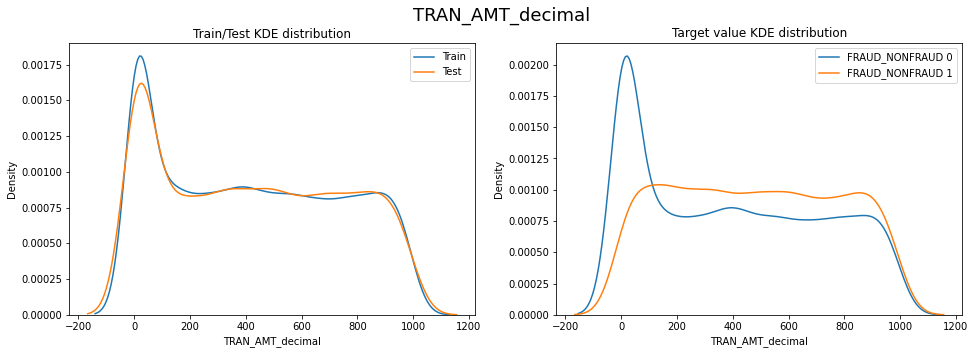

In [ ]:
plot_density('TRAN_AMT_decimal')

In [88]:
# TRAN_AMT
train['ACCT_PRE_TRAN_AVAIL_BAL_decimal'] = ((train['ACCT_PRE_TRAN_AVAIL_BAL'] - train['ACCT_PRE_TRAN_AVAIL_BAL'].astype(int)) * 1000).astype(int)
test['ACCT_PRE_TRAN_AVAIL_BAL_decimal'] = ((test['ACCT_PRE_TRAN_AVAIL_BAL'] - test['ACCT_PRE_TRAN_AVAIL_BAL'].astype(int)) * 1000).astype(int)

train['ACCT_PRE_TRAN_AVAIL_BAL_decimal_lenght'] = train['ACCT_PRE_TRAN_AVAIL_BAL'].astype(str).str.split('.', expand=True)[1].str.len()
test['ACCT_PRE_TRAN_AVAIL_BAL_decimal_lenght'] = test['ACCT_PRE_TRAN_AVAIL_BAL'].astype(str).str.split('.', expand=True)[1].str.len()

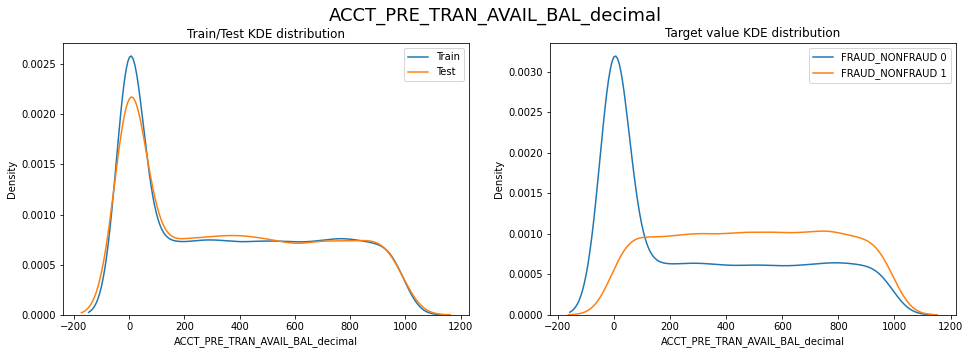

In [ ]:
plot_density('ACCT_PRE_TRAN_AVAIL_BAL_decimal')

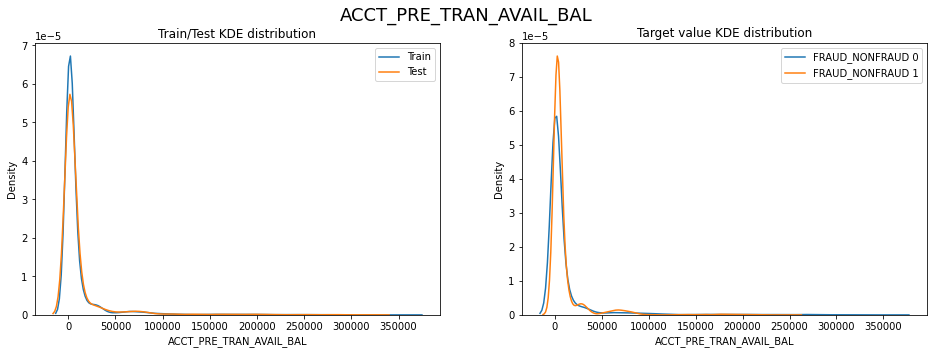

In [ ]:
plot_density('ACCT_PRE_TRAN_AVAIL_BAL')

Test and train have same amount decimal distribution. In train dataset, non-fraud is found more around 0 decimal

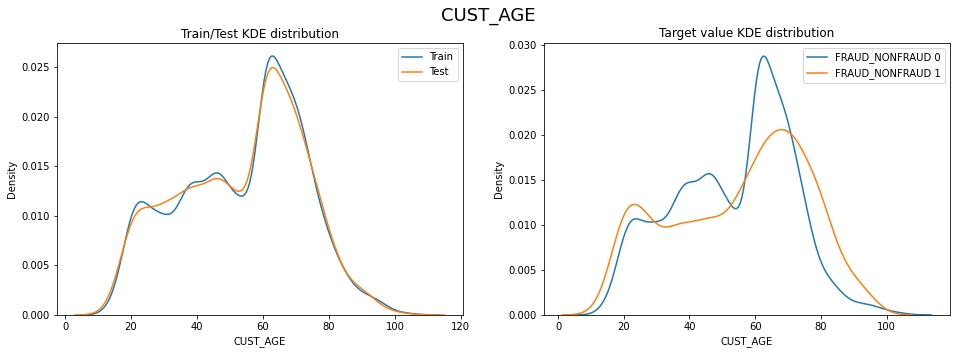

In [ ]:
# CUST_AGE
plot_density('CUST_AGE')

In [46]:
# train['CARR_NAME'] = train['CARR_NAME'].str.split(" ", expand=True)[0]
# test['CARR_NAME'] = test['CARR_NAME'].str.split(" ", expand=True)[0]

In [ ]:
carrier = train[["FRAUD_NONFRAUD", "CARR_NAME"]].groupby(["CARR_NAME"]).FRAUD_NONFRAUD.agg(["mean", "count"]).reset_index()
carrier  = carrier.rename(columns={"CARR_NAME" : "CARR_NAME", "mean": "CARR_NAME_fraud_rate", "count": "CARR_NAME_count"})
carrier.sort_values(by=["CARR_NAME_fraud_rate", "CARR_NAME_count"], ascending=False).head(10)

,CARR_NAME,CARR_NAME_fraud_rate,CARR_NAME_count
170,highwinds,1.0,19
123,eonix,1.0,8
79,colombia,1.0,7
99,cyber,1.0,7
114,direct,1.0,7
446,vegasnap,1.0,7
185,hz,1.0,6
327,quadranet,1.0,6
351,scancom,1.0,6
428,tristate,1.0,6


In [ ]:
train.select_dtypes(include='object')

,CARR_NAME,RGN_NAME,STATE_PRVNC_TXT,ALERT_TRGR_CD,DVC_TYPE_TXT,AUTHC_PRIM_TYPE_CD,CUST_STATE,ACTVY_DT
0,cox,southwest,nevada,MOBL,NaN,UN_PWD,NV,5/3/2021
1,charter,southwest,california,MOBL,NaN,FACE_ID,CA,1/13/2021
2,utah,mountain,utah,ONLN,DESKTOP,UN_PWD,MD,4/8/2021
3,t-mobile,southwest,california,MOBL,MOBILE,UN_PWD,NV,8/10/2021
4,cogent,south central,texas,MOBL,MOBILE,UN_PWD,UT,6/27/2021
...,...,...,...,...,...,...,...,...
13995,cellco,southwest,california,MOBL,MOBILE,UN_PWD,CA,3/12/2021
13996,t-mobile,southwest,california,MOBL,MOBILE,FACE_ID,CO,6/11/2021
13997,att,southwest,california,MOBL,DESKTOP,UN_PWD,FL,5/16/2021
13998,NaN,NaN,NaN,ONLN,DESKTOP,UN_PWD,CA,5/11/2021


### 2.3 Missing value count

In [42]:
train['mis_count'] = train.isnull().sum(axis=1)
test['mis_count'] = test.isnull().sum(axis=1)

In [43]:
train.columns

Index(['TRAN_AMT', 'ACCT_PRE_TRAN_AVAIL_BAL', 'CUST_AGE', 'OPEN_ACCT_CT',
       'WF_dvc_age', 'PWD_UPDT_TS', 'CARR_NAME', 'RGN_NAME', 'STATE_PRVNC_TXT',
       'ALERT_TRGR_CD', 'DVC_TYPE_TXT', 'AUTHC_PRIM_TYPE_CD',
       'AUTHC_SCNDRY_STAT_TXT', 'CUST_ZIP', 'CUST_STATE', 'PH_NUM_UPDT_TS',
       'CUST_SINCE_DT', 'TRAN_TS', 'ACTN_CD', 'ACTN_INTNL_TXT', 'TRAN_TYPE_CD',
       'FRAUD_NONFRAUD', 'Wrong_date', 'PWD_UPDT_YR', 'PWD_UPDT_MO',
       'PWD_UPDT_WKD', 'PWD_UPDT_HR', 'PH_NUM_UPDT_YR', 'PH_NUM_UPDT_MO',
       'PH_NUM_UPDT_WKD', 'PH_NUM_UPDT_HR', 'CUST_SINCE_YR', 'CUST_SINCE_MO',
       'SCUST_SINCE_WKD', 'TRAN_TS_YR', 'TRAN_TS_MO', 'TRAN_TS_WKD',
       'TRAN_TS_HR', 'PWD_UPDT_YR_FE', 'PWD_UPDT_MO_FE', 'PWD_UPDT_WKD_FE',
       'PWD_UPDT_HR_FE', 'PH_NUM_UPDT_YR_FE', 'PH_NUM_UPDT_MO_FE',
       'PH_NUM_UPDT_WKD_FE', 'PH_NUM_UPDT_HR_FE', 'CUST_SINCE_YR_FE',
       'CUST_SINCE_MO_FE', 'SCUST_SINCE_WKD_FE', 'TRAN_TS_YR_FE',
       'TRAN_TS_MO_FE', 'TRAN_TS_WKD_FE', 'TRAN_TS_HR_FE',


In [44]:
test.columns

Index(['dataset_id', 'TRAN_AMT', 'ACCT_PRE_TRAN_AVAIL_BAL', 'CUST_AGE',
       'OPEN_ACCT_CT', 'WF_dvc_age', 'PWD_UPDT_TS', 'CARR_NAME', 'RGN_NAME',
       'STATE_PRVNC_TXT', 'ALERT_TRGR_CD', 'DVC_TYPE_TXT',
       'AUTHC_PRIM_TYPE_CD', 'AUTHC_SCNDRY_STAT_TXT', 'CUST_ZIP', 'CUST_STATE',
       'PH_NUM_UPDT_TS', 'CUST_SINCE_DT', 'TRAN_TS', 'ACTN_CD',
       'ACTN_INTNL_TXT', 'TRAN_TYPE_CD', 'Wrong_date', 'PWD_UPDT_YR',
       'PWD_UPDT_MO', 'PWD_UPDT_WKD', 'PWD_UPDT_HR', 'PH_NUM_UPDT_YR',
       'PH_NUM_UPDT_MO', 'PH_NUM_UPDT_WKD', 'PH_NUM_UPDT_HR', 'CUST_SINCE_YR',
       'CUST_SINCE_MO', 'SCUST_SINCE_WKD', 'TRAN_TS_YR', 'TRAN_TS_MO',
       'TRAN_TS_WKD', 'TRAN_TS_HR', 'PWD_UPDT_YR_FE', 'PWD_UPDT_MO_FE',
       'PWD_UPDT_WKD_FE', 'PWD_UPDT_HR_FE', 'PH_NUM_UPDT_YR_FE',
       'PH_NUM_UPDT_MO_FE', 'PH_NUM_UPDT_WKD_FE', 'PH_NUM_UPDT_HR_FE',
       'CUST_SINCE_YR_FE', 'CUST_SINCE_MO_FE', 'SCUST_SINCE_WKD_FE',
       'TRAN_TS_YR_FE', 'TRAN_TS_MO_FE', 'TRAN_TS_WKD_FE', 'TRAN_TS_HR_FE',
    

Save the date after FE

In [46]:
train.to_csv('train_FE.csv', index=False)
!cp train_FE.csv "/content/drive/MyDrive/WellsFargo competition/"

test.to_csv('test_FE.csv', index=False)
!cp test_FE.csv "/content/drive/MyDrive/WellsFargo competition/"

## 3. Feature Selection

In [47]:
fs_list = train.columns.tolist()
fs_list.remove('FRAUD_NONFRAUD')
fs_list.remove('PWD_UPDT_TS')
fs_list.remove('PH_NUM_UPDT_TS')
fs_list.remove('CUST_SINCE_DT')
fs_list.remove('TRAN_TS')


In [48]:
for col in train[fs_list]:
  if train[col].dtype == 'object':
    le = LabelEncoder()
    le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
    train[col] = le.transform(list(train[col].astype(str).values))
    test[col] = le.transform(list(test[col].astype(str).values))

In [97]:
len(fs_list)

74

In [49]:
X = train[fs_list]
y = train['FRAUD_NONFRAUD']
clf = lgb.LGBMClassifier()

cross_val_score(clf, X, y, cv=5, scoring='f1', error_score="raise").mean()

0.9771013893523722

In [50]:
X = train[fs_list]
y = train['FRAUD_NONFRAUD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47, stratify=y)
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
y_pred = np.rint(clf.predict_proba(X_test)[:, 1])
f1_score(y_test, y_pred, average=None)

array([0.94608837, 0.97758301])

In [51]:
importance= pd.DataFrame()
importance["Features"] = train[fs_list].columns
importance["Score"] = clf.feature_importances_

fs_after = importance[importance['Score']>0]['Features'].tolist()
fs_remove = importance[importance['Score']==0]['Features'].tolist()

In [52]:
len(fs_after)

62

In [53]:
importance.sort_values(by = "Score", ascending=False).head(50)

,Features,Score
1,ACCT_PRE_TRAN_AVAIL_BAL,236
0,TRAN_AMT,234
18,PWD_UPDT_YR,124
4,WF_dvc_age,119
53,TRAN_AMT_CUST_AGE_CUST_SINCE_DT_mean,118
36,PWD_UPDT_HR_FE,93
65,ACCT_PRE_TRAN_AVAIL_BAL_RGN_NAME_CUST_STATE_CU...,91
57,TRAN_AMT_RGN_NAME_CUST_STATE_CUST_ZIP_mean,91
34,PWD_UPDT_MO_FE,80
9,DVC_TYPE_TXT,78


In [54]:
fs_after

['TRAN_AMT',
 'ACCT_PRE_TRAN_AVAIL_BAL',
 'CUST_AGE',
 'OPEN_ACCT_CT',
 'WF_dvc_age',
 'CARR_NAME',
 'RGN_NAME',
 'STATE_PRVNC_TXT',
 'ALERT_TRGR_CD',
 'DVC_TYPE_TXT',
 'AUTHC_PRIM_TYPE_CD',
 'AUTHC_SCNDRY_STAT_TXT',
 'CUST_ZIP',
 'CUST_STATE',
 'Wrong_date',
 'PWD_UPDT_YR',
 'PWD_UPDT_MO',
 'PWD_UPDT_WKD',
 'PWD_UPDT_HR',
 'PH_NUM_UPDT_YR',
 'PH_NUM_UPDT_MO',
 'PH_NUM_UPDT_WKD',
 'PH_NUM_UPDT_HR',
 'CUST_SINCE_YR',
 'CUST_SINCE_MO',
 'SCUST_SINCE_WKD',
 'TRAN_TS_MO',
 'TRAN_TS_WKD',
 'TRAN_TS_HR',
 'PWD_UPDT_YR_FE',
 'PWD_UPDT_MO_FE',
 'PWD_UPDT_WKD_FE',
 'PWD_UPDT_HR_FE',
 'PH_NUM_UPDT_YR_FE',
 'PH_NUM_UPDT_MO_FE',
 'PH_NUM_UPDT_WKD_FE',
 'PH_NUM_UPDT_HR_FE',
 'CUST_SINCE_YR_FE',
 'CUST_SINCE_MO_FE',
 'SCUST_SINCE_WKD_FE',
 'TRAN_TS_MO_FE',
 'TRAN_TS_WKD_FE',
 'TRAN_TS_HR_FE',
 'CUST_AGE_CUST_SINCE_DT',
 'RGN_NAME_CUST_STATE',
 'RGN_NAME_CUST_STATE_CUST_ZIP',
 'CUST_AGE_CUST_SINCE_DT_RGN_NAME_CUST_STATE_CUST_ZIP',
 'CARR_NAME_WF_dvc_age',
 'TRAN_AMT_CUST_AGE_CUST_SINCE_DT_mean',
 'TR

In [55]:
fs_remove

['ACTN_CD',
 'ACTN_INTNL_TXT',
 'TRAN_TYPE_CD',
 'TRAN_TS_YR',
 'TRAN_TS_YR_FE',
 'TRAN_AMT_CUST_AGE_CUST_SINCE_DT_RGN_NAME_CUST_STATE_CUST_ZIP_mean',
 'TRAN_AMT_CUST_AGE_CUST_SINCE_DT_RGN_NAME_CUST_STATE_CUST_ZIP_std',
 'ACCT_PRE_TRAN_AVAIL_BAL_CUST_AGE_CUST_SINCE_DT_std',
 'ACCT_PRE_TRAN_AVAIL_BAL_CUST_AGE_CUST_SINCE_DT_RGN_NAME_CUST_STATE_CUST_ZIP_mean',
 'ACCT_PRE_TRAN_AVAIL_BAL_CUST_AGE_CUST_SINCE_DT_RGN_NAME_CUST_STATE_CUST_ZIP_std']

In [56]:
X = train[fs_after]
y = train['FRAUD_NONFRAUD']
clf = lgb.LGBMClassifier()

cross_val_score(clf, X, y, cv=5, scoring='f1', error_score="raise").mean()

0.9770544487136534

In [57]:
X = train[fs_after]
y = train['FRAUD_NONFRAUD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47, stratify=y)
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
y_pred = np.rint(clf.predict_proba(X_test)[:, 1])
f1_score(y_test, y_pred, average=None)

array([0.94608837, 0.97758301])

In [58]:
X = train[fs_after]
y = train['FRAUD_NONFRAUD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47, stratify=y)
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

f1_score(y_test, np.rint(clf.predict_proba(X_test)[:, 1]), average='weighted')

0.9682171031000976

In [59]:
y_test.value_counts()

1    2951
0    1249
Name: FRAUD_NONFRAUD, dtype: int64

In [60]:
# confusion matrix
confusion_matrix(y_test, y_pred)

array([[1167,   82],
       [  51, 2900]])

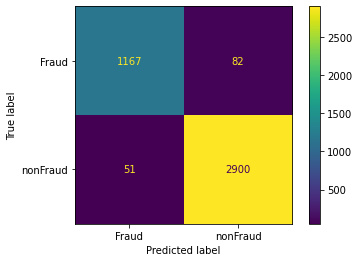

In [62]:
plot_confusion_matrix(clf, X_test, y_test, display_labels=['Fraud', 'nonFraud'], values_format='d')

## 4 Model (LGBM) Tuning using OPTUNA

In [ ]:
!pip install optuna

In [93]:
import optuna  # pip install optuna

In [96]:
from optuna.integration import LightGBMPruningCallback

def objective(trial, X, y):
 

    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        # "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 20, 1000, step=20),
        "max_depth": trial.suggest_int("max_depth", -1, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 200, step=20),
        "lambda_l1": trial.suggest_loguniform("lambda_l1",1e-3, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-3, 10.0),
        # "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1, step=0.05),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1, step=0.05),
        "min_sum_hessian_in_leaf": trial.suggest_loguniform("min_sum_hessian_in_leaf",1e-3, 20.0),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgb.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric='auc',
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, 'auc')
            ],  # Add a pruning callback
        )
        preds = np.rint(model.predict_proba(X_test)[:, 1])
        cv_scores[idx] = f1_score(y_test, preds, average='weighted')

    return np.mean(cv_scores)

In [97]:
%%time
X = train[fs_after]
y = train['FRAUD_NONFRAUD']
study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=50)

[I 2021-10-13 03:27:47,757] A new study created in memory with name: LGBM Classifier


[1]	valid_0's auc: 0.971868	valid_0's binary_logloss: 0.588068
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.971868	valid_0's binary_logloss: 0.56918
[3]	valid_0's auc: 0.973788	valid_0's binary_logloss: 0.55147
[4]	valid_0's auc: 0.973788	valid_0's binary_logloss: 0.53499
[5]	valid_0's auc: 0.97396	valid_0's binary_logloss: 0.519602
[6]	valid_0's auc: 0.976221	valid_0's binary_logloss: 0.504957
[7]	valid_0's auc: 0.976548	valid_0's binary_logloss: 0.491179
[8]	valid_0's auc: 0.976926	valid_0's binary_logloss: 0.478173
[9]	valid_0's auc: 0.977029	valid_0's binary_logloss: 0.465991
[10]	valid_0's auc: 0.977262	valid_0's binary_logloss: 0.4543
[11]	valid_0's auc: 0.977352	valid_0's binary_logloss: 0.443197
[12]	valid_0's auc: 0.977336	valid_0's binary_logloss: 0.43255
[13]	valid_0's auc: 0.977675	valid_0's binary_logloss: 0.422338
[14]	valid_0's auc: 0.978224	valid_0's binary_logloss: 0.412415
[15]	valid_0's auc: 0.978624	valid_0's binary_logloss: 0.

[I 2021-10-13 03:27:52,406] Trial 0 finished with value: 0.9528223810536736 and parameters: {'learning_rate': 0.028569197982897684, 'num_leaves': 820, 'max_depth': 7, 'min_data_in_leaf': 180, 'lambda_l1': 0.016456073834325735, 'lambda_l2': 2.3605421475569446, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 1.0, 'min_sum_hessian_in_leaf': 2.0442656733271183}. Best is trial 0 with value: 0.9528223810536736.


[88]	valid_0's auc: 0.988016	valid_0's binary_logloss: 0.157089
[89]	valid_0's auc: 0.988064	valid_0's binary_logloss: 0.156084
[90]	valid_0's auc: 0.988147	valid_0's binary_logloss: 0.155057
[91]	valid_0's auc: 0.988153	valid_0's binary_logloss: 0.154206
[92]	valid_0's auc: 0.988236	valid_0's binary_logloss: 0.153272
[93]	valid_0's auc: 0.988273	valid_0's binary_logloss: 0.152333
[94]	valid_0's auc: 0.988416	valid_0's binary_logloss: 0.151209
[95]	valid_0's auc: 0.988487	valid_0's binary_logloss: 0.150265
[96]	valid_0's auc: 0.988521	valid_0's binary_logloss: 0.149419
[97]	valid_0's auc: 0.988592	valid_0's binary_logloss: 0.148488
[98]	valid_0's auc: 0.988699	valid_0's binary_logloss: 0.147516
[99]	valid_0's auc: 0.98874	valid_0's binary_logloss: 0.146701
[100]	valid_0's auc: 0.988848	valid_0's binary_logloss: 0.145764
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.988848	valid_0's binary_logloss: 0.145764
[1]	valid_0's auc: 0.970092	valid_0's binary_logloss: 0

[I 2021-10-13 03:27:56,542] Trial 1 finished with value: 0.9625270770197825 and parameters: {'learning_rate': 0.053709863525135654, 'num_leaves': 460, 'max_depth': 9, 'min_data_in_leaf': 20, 'lambda_l1': 1.1719193662351877, 'lambda_l2': 0.002438547121195215, 'bagging_fraction': 0.4, 'bagging_freq': 5, 'feature_fraction': 0.8, 'min_sum_hessian_in_leaf': 2.3175961575438166}. Best is trial 1 with value: 0.9625270770197825.


[1]	valid_0's auc: 0.972396	valid_0's binary_logloss: 0.586312
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.974353	valid_0's binary_logloss: 0.565965
[3]	valid_0's auc: 0.97444	valid_0's binary_logloss: 0.549133
[4]	valid_0's auc: 0.975116	valid_0's binary_logloss: 0.531298
[5]	valid_0's auc: 0.976273	valid_0's binary_logloss: 0.514598
[6]	valid_0's auc: 0.977072	valid_0's binary_logloss: 0.498983
[7]	valid_0's auc: 0.977552	valid_0's binary_logloss: 0.484339
[8]	valid_0's auc: 0.977845	valid_0's binary_logloss: 0.470565
[9]	valid_0's auc: 0.978495	valid_0's binary_logloss: 0.457373
[10]	valid_0's auc: 0.978801	valid_0's binary_logloss: 0.44488
[11]	valid_0's auc: 0.979048	valid_0's binary_logloss: 0.432912
[12]	valid_0's auc: 0.978985	valid_0's binary_logloss: 0.42166
[13]	valid_0's auc: 0.978714	valid_0's binary_logloss: 0.411156
[14]	valid_0's auc: 0.979243	valid_0's binary_logloss: 0.400959
[15]	valid_0's auc: 0.97916	valid_0's binary_logloss:

[I 2021-10-13 03:28:00,345] Trial 2 finished with value: 0.95139132980963 and parameters: {'learning_rate': 0.030444570123022537, 'num_leaves': 540, 'max_depth': 5, 'min_data_in_leaf': 100, 'lambda_l1': 0.011287089601174614, 'lambda_l2': 0.016909666413081906, 'bagging_fraction': 0.7000000000000001, 'bagging_freq': 5, 'feature_fraction': 0.8500000000000001, 'min_sum_hessian_in_leaf': 0.0027224092767263483}. Best is trial 1 with value: 0.9625270770197825.


[1]	valid_0's auc: 0.855926	valid_0's binary_logloss: 0.592222
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.855926	valid_0's binary_logloss: 0.577324
[3]	valid_0's auc: 0.861	valid_0's binary_logloss: 0.568016
[4]	valid_0's auc: 0.861209	valid_0's binary_logloss: 0.555312
[5]	valid_0's auc: 0.861207	valid_0's binary_logloss: 0.543568
[6]	valid_0's auc: 0.861196	valid_0's binary_logloss: 0.532666
[7]	valid_0's auc: 0.861178	valid_0's binary_logloss: 0.522544
[8]	valid_0's auc: 0.861178	valid_0's binary_logloss: 0.513114
[9]	valid_0's auc: 0.861227	valid_0's binary_logloss: 0.503884
[10]	valid_0's auc: 0.860992	valid_0's binary_logloss: 0.495235
[11]	valid_0's auc: 0.861004	valid_0's binary_logloss: 0.487083
[12]	valid_0's auc: 0.861	valid_0's binary_logloss: 0.479448
[13]	valid_0's auc: 0.860862	valid_0's binary_logloss: 0.472809
[14]	valid_0's auc: 0.901212	valid_0's binary_logloss: 0.467547
[15]	valid_0's auc: 0.925866	valid_0's binary_logloss: 0

[I 2021-10-13 03:28:02,560] Trial 3 finished with value: 0.9181587960406183 and parameters: {'learning_rate': 0.03316089827195687, 'num_leaves': 740, 'max_depth': 1, 'min_data_in_leaf': 200, 'lambda_l1': 0.013718190378745465, 'lambda_l2': 0.7904665627382146, 'bagging_fraction': 0.9, 'bagging_freq': 2, 'feature_fraction': 0.65, 'min_sum_hessian_in_leaf': 0.004398676315547932}. Best is trial 1 with value: 0.9625270770197825.



[78]	valid_0's auc: 0.964176	valid_0's binary_logloss: 0.292234
[79]	valid_0's auc: 0.964234	valid_0's binary_logloss: 0.290834
[80]	valid_0's auc: 0.964458	valid_0's binary_logloss: 0.289604
[81]	valid_0's auc: 0.964921	valid_0's binary_logloss: 0.288321
[82]	valid_0's auc: 0.965503	valid_0's binary_logloss: 0.287059
[83]	valid_0's auc: 0.965387	valid_0's binary_logloss: 0.285743
[84]	valid_0's auc: 0.965544	valid_0's binary_logloss: 0.284472
[85]	valid_0's auc: 0.966066	valid_0's binary_logloss: 0.28326
[86]	valid_0's auc: 0.96674	valid_0's binary_logloss: 0.282031
[87]	valid_0's auc: 0.966888	valid_0's binary_logloss: 0.280823
[88]	valid_0's auc: 0.967065	valid_0's binary_logloss: 0.279682
[89]	valid_0's auc: 0.967732	valid_0's binary_logloss: 0.278556
[90]	valid_0's auc: 0.968084	valid_0's binary_logloss: 0.277407
[91]	valid_0's auc: 0.967939	valid_0's binary_logloss: 0.27616
[92]	valid_0's auc: 0.968106	valid_0's binary_logloss: 0.274967
[93]	valid_0's auc: 0.967962	valid_0's bin

[I 2021-10-13 03:28:05,968] Trial 4 finished with value: 0.9646874141164099 and parameters: {'learning_rate': 0.0739595227946492, 'num_leaves': 860, 'max_depth': 9, 'min_data_in_leaf': 60, 'lambda_l1': 0.027904899702971154, 'lambda_l2': 3.646163852406852, 'bagging_fraction': 0.5, 'bagging_freq': 4, 'feature_fraction': 0.4, 'min_sum_hessian_in_leaf': 0.4272561761870172}. Best is trial 4 with value: 0.9646874141164099.


[90]	valid_0's auc: 0.992206	valid_0's binary_logloss: 0.105195
[91]	valid_0's auc: 0.992175	valid_0's binary_logloss: 0.105122
[92]	valid_0's auc: 0.992158	valid_0's binary_logloss: 0.105006
[93]	valid_0's auc: 0.992228	valid_0's binary_logloss: 0.10457
[94]	valid_0's auc: 0.992258	valid_0's binary_logloss: 0.104147
[95]	valid_0's auc: 0.9923	valid_0's binary_logloss: 0.103771
[96]	valid_0's auc: 0.992256	valid_0's binary_logloss: 0.10375
[97]	valid_0's auc: 0.992313	valid_0's binary_logloss: 0.103369
[98]	valid_0's auc: 0.992359	valid_0's binary_logloss: 0.103067
[99]	valid_0's auc: 0.992419	valid_0's binary_logloss: 0.102524
[100]	valid_0's auc: 0.992487	valid_0's binary_logloss: 0.102047
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.992487	valid_0's binary_logloss: 0.102047


[I 2021-10-13 03:28:06,119] Trial 5 pruned. Trial was pruned at iteration 0.


[1]	valid_0's auc: 0.972967	valid_0's binary_logloss: 0.57378
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.975636	valid_0's binary_logloss: 0.543253
[3]	valid_0's auc: 0.975527	valid_0's binary_logloss: 0.516018
[4]	valid_0's auc: 0.975843	valid_0's binary_logloss: 0.491404
[5]	valid_0's auc: 0.976481	valid_0's binary_logloss: 0.469142
[6]	valid_0's auc: 0.978122	valid_0's binary_logloss: 0.448755
[7]	valid_0's auc: 0.978453	valid_0's binary_logloss: 0.429668
[8]	valid_0's auc: 0.978626	valid_0's binary_logloss: 0.41236
[9]	valid_0's auc: 0.978913	valid_0's binary_logloss: 0.396519
[10]	valid_0's auc: 0.978989	valid_0's binary_logloss: 0.381849
[11]	valid_0's auc: 0.979402	valid_0's binary_logloss: 0.367793
[12]	valid_0's auc: 0.979611	valid_0's binary_logloss: 0.354679
[13]	valid_0's auc: 0.979747	valid_0's binary_logloss: 0.34286
[14]	valid_0's auc: 0.980068	valid_0's binary_logloss: 0.331523
[15]	valid_0's auc: 0.980146	valid_0's binary_logloss

[I 2021-10-13 03:28:10,373] Trial 6 finished with value: 0.9616003273464809 and parameters: {'learning_rate': 0.04865292371467235, 'num_leaves': 80, 'max_depth': 7, 'min_data_in_leaf': 100, 'lambda_l1': 0.044256541456558066, 'lambda_l2': 0.45555045930569976, 'bagging_fraction': 0.55, 'bagging_freq': 5, 'feature_fraction': 0.9500000000000001, 'min_sum_hessian_in_leaf': 0.02294412373378278}. Best is trial 4 with value: 0.9646874141164099.


[96]	valid_0's auc: 0.991561	valid_0's binary_logloss: 0.112005
[97]	valid_0's auc: 0.991633	valid_0's binary_logloss: 0.111343
[98]	valid_0's auc: 0.991658	valid_0's binary_logloss: 0.110877
[99]	valid_0's auc: 0.991687	valid_0's binary_logloss: 0.110456
[100]	valid_0's auc: 0.991706	valid_0's binary_logloss: 0.110071
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.991706	valid_0's binary_logloss: 0.110071


[I 2021-10-13 03:28:10,528] Trial 7 pruned. Trial was pruned at iteration 0.
[I 2021-10-13 03:28:10,764] Trial 8 pruned. Trial was pruned at iteration 9.
[I 2021-10-13 03:28:10,897] Trial 9 pruned. Trial was pruned at iteration 0.


[1]	valid_0's auc: 0.971875	valid_0's binary_logloss: 0.593877
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.976249	valid_0's binary_logloss: 0.57981
[3]	valid_0's auc: 0.977655	valid_0's binary_logloss: 0.566564
[4]	valid_0's auc: 0.977798	valid_0's binary_logloss: 0.554072
[5]	valid_0's auc: 0.978229	valid_0's binary_logloss: 0.541962
[6]	valid_0's auc: 0.978279	valid_0's binary_logloss: 0.530489
[7]	valid_0's auc: 0.978546	valid_0's binary_logloss: 0.519363
[8]	valid_0's auc: 0.978641	valid_0's binary_logloss: 0.508887
[9]	valid_0's auc: 0.978753	valid_0's binary_logloss: 0.498958


[I 2021-10-13 03:28:11,122] Trial 10 pruned. Trial was pruned at iteration 0.


[1]	valid_0's auc: 0.972019	valid_0's binary_logloss: 0.560793
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.976793	valid_0's binary_logloss: 0.520612
[3]	valid_0's auc: 0.978536	valid_0's binary_logloss: 0.488071
[4]	valid_0's auc: 0.979519	valid_0's binary_logloss: 0.45767
[5]	valid_0's auc: 0.980746	valid_0's binary_logloss: 0.430363
[6]	valid_0's auc: 0.980746	valid_0's binary_logloss: 0.40619
[7]	valid_0's auc: 0.98107	valid_0's binary_logloss: 0.384153
[8]	valid_0's auc: 0.981197	valid_0's binary_logloss: 0.364314
[9]	valid_0's auc: 0.98166	valid_0's binary_logloss: 0.346806
[10]	valid_0's auc: 0.981792	valid_0's binary_logloss: 0.331083
[11]	valid_0's auc: 0.9818	valid_0's binary_logloss: 0.316649
[12]	valid_0's auc: 0.981809	valid_0's binary_logloss: 0.303682
[13]	valid_0's auc: 0.98207	valid_0's binary_logloss: 0.291449
[14]	valid_0's auc: 0.982085	valid_0's binary_logloss: 0.280391
[15]	valid_0's auc: 0.982148	valid_0's binary_logloss: 0.

[I 2021-10-13 03:28:14,518] Trial 11 finished with value: 0.9618176008635247 and parameters: {'learning_rate': 0.06774466580179629, 'num_leaves': 260, 'max_depth': 8, 'min_data_in_leaf': 20, 'lambda_l1': 0.282825189929904, 'lambda_l2': 0.0015963073721886882, 'bagging_fraction': 0.4, 'bagging_freq': 4, 'feature_fraction': 0.8, 'min_sum_hessian_in_leaf': 15.911637137345556}. Best is trial 4 with value: 0.9646874141164099.


[86]	valid_0's auc: 0.99096	valid_0's binary_logloss: 0.112882
[87]	valid_0's auc: 0.990913	valid_0's binary_logloss: 0.112925
[88]	valid_0's auc: 0.990872	valid_0's binary_logloss: 0.113031
[89]	valid_0's auc: 0.990916	valid_0's binary_logloss: 0.112719
[90]	valid_0's auc: 0.99096	valid_0's binary_logloss: 0.112393
[91]	valid_0's auc: 0.991007	valid_0's binary_logloss: 0.112132
[92]	valid_0's auc: 0.991022	valid_0's binary_logloss: 0.1119
[93]	valid_0's auc: 0.991049	valid_0's binary_logloss: 0.111655
[94]	valid_0's auc: 0.991044	valid_0's binary_logloss: 0.111468
[95]	valid_0's auc: 0.991124	valid_0's binary_logloss: 0.11101
[96]	valid_0's auc: 0.991154	valid_0's binary_logloss: 0.110863
[97]	valid_0's auc: 0.99118	valid_0's binary_logloss: 0.110618
[98]	valid_0's auc: 0.991249	valid_0's binary_logloss: 0.110237
[99]	valid_0's auc: 0.99129	valid_0's binary_logloss: 0.110025
[100]	valid_0's auc: 0.991321	valid_0's binary_logloss: 0.109741
Did not meet early stopping. Best iteration is

[I 2021-10-13 03:28:14,706] Trial 12 pruned. Trial was pruned at iteration 0.


[1]	valid_0's auc: 0.974667	valid_0's binary_logloss: 0.537623
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.978291	valid_0's binary_logloss: 0.483914
[3]	valid_0's auc: 0.981646	valid_0's binary_logloss: 0.447707
[4]	valid_0's auc: 0.983882	valid_0's binary_logloss: 0.407847
[5]	valid_0's auc: 0.986065	valid_0's binary_logloss: 0.37682
[6]	valid_0's auc: 0.986033	valid_0's binary_logloss: 0.349392
[7]	valid_0's auc: 0.986367	valid_0's binary_logloss: 0.324662
[8]	valid_0's auc: 0.986766	valid_0's binary_logloss: 0.30368
[9]	valid_0's auc: 0.986969	valid_0's binary_logloss: 0.284881
[10]	valid_0's auc: 0.987027	valid_0's binary_logloss: 0.268255
[11]	valid_0's auc: 0.987028	valid_0's binary_logloss: 0.253521
[12]	valid_0's auc: 0.986963	valid_0's binary_logloss: 0.240616
[13]	valid_0's auc: 0.98716	valid_0's binary_logloss: 0.228917
[14]	valid_0's auc: 0.98766	valid_0's binary_logloss: 0.21973
[15]	valid_0's auc: 0.987897	valid_0's binary_logloss: 

[I 2021-10-13 03:28:19,585] Trial 13 finished with value: 0.9654168244498404 and parameters: {'learning_rate': 0.0967515988159008, 'num_leaves': 300, 'max_depth': -1, 'min_data_in_leaf': 40, 'lambda_l1': 1.526906272600088, 'lambda_l2': 0.006386944741876945, 'bagging_fraction': 0.7000000000000001, 'bagging_freq': 4, 'feature_fraction': 0.55, 'min_sum_hessian_in_leaf': 1.1276223889432362}. Best is trial 13 with value: 0.9654168244498404.


[1]	valid_0's auc: 0.974255	valid_0's binary_logloss: 0.537719
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.978426	valid_0's binary_logloss: 0.483592
[3]	valid_0's auc: 0.981031	valid_0's binary_logloss: 0.44642
[4]	valid_0's auc: 0.981371	valid_0's binary_logloss: 0.415473
[5]	valid_0's auc: 0.984351	valid_0's binary_logloss: 0.383379
[6]	valid_0's auc: 0.983852	valid_0's binary_logloss: 0.362059
[7]	valid_0's auc: 0.984634	valid_0's binary_logloss: 0.336011
[8]	valid_0's auc: 0.985662	valid_0's binary_logloss: 0.316239
[9]	valid_0's auc: 0.986192	valid_0's binary_logloss: 0.295393
[10]	valid_0's auc: 0.986582	valid_0's binary_logloss: 0.27738
[11]	valid_0's auc: 0.986864	valid_0's binary_logloss: 0.260916
[12]	valid_0's auc: 0.987035	valid_0's binary_logloss: 0.246592
[13]	valid_0's auc: 0.987498	valid_0's binary_logloss: 0.233635
[14]	valid_0's auc: 0.987513	valid_0's binary_logloss: 0.225256
[15]	valid_0's auc: 0.987685	valid_0's binary_loglos

[I 2021-10-13 03:28:24,604] Trial 14 finished with value: 0.9663645821085997 and parameters: {'learning_rate': 0.09755105871568558, 'num_leaves': 280, 'max_depth': -1, 'min_data_in_leaf': 60, 'lambda_l1': 0.12162482807633003, 'lambda_l2': 0.009312165250254235, 'bagging_fraction': 0.7000000000000001, 'bagging_freq': 3, 'feature_fraction': 0.4, 'min_sum_hessian_in_leaf': 0.514621871370952}. Best is trial 14 with value: 0.9663645821085997.


[1]	valid_0's auc: 0.974913	valid_0's binary_logloss: 0.537845
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.978531	valid_0's binary_logloss: 0.48373
[3]	valid_0's auc: 0.981267	valid_0's binary_logloss: 0.447159
[4]	valid_0's auc: 0.983372	valid_0's binary_logloss: 0.408022
[5]	valid_0's auc: 0.98473	valid_0's binary_logloss: 0.377258
[6]	valid_0's auc: 0.985335	valid_0's binary_logloss: 0.349256
[7]	valid_0's auc: 0.9859	valid_0's binary_logloss: 0.324559
[8]	valid_0's auc: 0.986261	valid_0's binary_logloss: 0.303592
[9]	valid_0's auc: 0.986387	valid_0's binary_logloss: 0.284834
[10]	valid_0's auc: 0.986488	valid_0's binary_logloss: 0.268318
[11]	valid_0's auc: 0.986759	valid_0's binary_logloss: 0.253128
[12]	valid_0's auc: 0.987013	valid_0's binary_logloss: 0.239787
[13]	valid_0's auc: 0.98712	valid_0's binary_logloss: 0.228232
[14]	valid_0's auc: 0.987564	valid_0's binary_logloss: 0.219151
[15]	valid_0's auc: 0.987819	valid_0's binary_logloss: 

[I 2021-10-13 03:28:30,254] Trial 15 finished with value: 0.9653345386347943 and parameters: {'learning_rate': 0.0967976988535116, 'num_leaves': 200, 'max_depth': -1, 'min_data_in_leaf': 60, 'lambda_l1': 0.15236907392275023, 'lambda_l2': 0.008529614048142268, 'bagging_fraction': 0.7000000000000001, 'bagging_freq': 3, 'feature_fraction': 0.55, 'min_sum_hessian_in_leaf': 0.03114666082045365}. Best is trial 14 with value: 0.9663645821085997.


[89]	valid_0's auc: 0.99317	valid_0's binary_logloss: 0.0957672
[90]	valid_0's auc: 0.993196	valid_0's binary_logloss: 0.0955701
[91]	valid_0's auc: 0.993161	valid_0's binary_logloss: 0.0958348
[92]	valid_0's auc: 0.993166	valid_0's binary_logloss: 0.0956938
[93]	valid_0's auc: 0.993202	valid_0's binary_logloss: 0.0956495
[94]	valid_0's auc: 0.993233	valid_0's binary_logloss: 0.0955489
[95]	valid_0's auc: 0.99326	valid_0's binary_logloss: 0.0953513
[96]	valid_0's auc: 0.993277	valid_0's binary_logloss: 0.0953823
[97]	valid_0's auc: 0.993281	valid_0's binary_logloss: 0.0953945
[98]	valid_0's auc: 0.993296	valid_0's binary_logloss: 0.0953091
[99]	valid_0's auc: 0.993309	valid_0's binary_logloss: 0.0951366
[100]	valid_0's auc: 0.99336	valid_0's binary_logloss: 0.095029
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.99336	valid_0's binary_logloss: 0.095029


[I 2021-10-13 03:28:30,414] Trial 16 pruned. Trial was pruned at iteration 0.
[I 2021-10-13 03:28:30,546] Trial 17 pruned. Trial was pruned at iteration 0.
[I 2021-10-13 03:28:30,698] Trial 18 pruned. Trial was pruned at iteration 0.


[1]	valid_0's auc: 0.974154	valid_0's binary_logloss: 0.544999
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.975662	valid_0's binary_logloss: 0.494708
[3]	valid_0's auc: 0.980361	valid_0's binary_logloss: 0.459456
[4]	valid_0's auc: 0.982224	valid_0's binary_logloss: 0.421473
[5]	valid_0's auc: 0.984601	valid_0's binary_logloss: 0.391597
[6]	valid_0's auc: 0.984918	valid_0's binary_logloss: 0.364283
[7]	valid_0's auc: 0.985306	valid_0's binary_logloss: 0.339745
[8]	valid_0's auc: 0.986284	valid_0's binary_logloss: 0.318252
[9]	valid_0's auc: 0.986575	valid_0's binary_logloss: 0.299816
[10]	valid_0's auc: 0.986847	valid_0's binary_logloss: 0.28315
[11]	valid_0's auc: 0.987009	valid_0's binary_logloss: 0.268139
[12]	valid_0's auc: 0.987252	valid_0's binary_logloss: 0.25449
[13]	valid_0's auc: 0.987351	valid_0's binary_logloss: 0.242385
[14]	valid_0's auc: 0.987723	valid_0's binary_logloss: 0.233055
[15]	valid_0's auc: 0.987833	valid_0's binary_loglos

[I 2021-10-13 03:28:37,607] Trial 19 finished with value: 0.9646738017466621 and parameters: {'learning_rate': 0.08628650229822961, 'num_leaves': 180, 'max_depth': 0, 'min_data_in_leaf': 40, 'lambda_l1': 0.005158238077608772, 'lambda_l2': 0.004266846721220344, 'bagging_fraction': 0.65, 'bagging_freq': 7, 'feature_fraction': 0.55, 'min_sum_hessian_in_leaf': 0.012188595017630938}. Best is trial 14 with value: 0.9663645821085997.


[94]	valid_0's auc: 0.993052	valid_0's binary_logloss: 0.0968166
[95]	valid_0's auc: 0.993055	valid_0's binary_logloss: 0.0965566
[96]	valid_0's auc: 0.9931	valid_0's binary_logloss: 0.0966911
[97]	valid_0's auc: 0.993102	valid_0's binary_logloss: 0.0967057
[98]	valid_0's auc: 0.993094	valid_0's binary_logloss: 0.0968372
[99]	valid_0's auc: 0.993108	valid_0's binary_logloss: 0.0966703
[100]	valid_0's auc: 0.993124	valid_0's binary_logloss: 0.0967604
Did not meet early stopping. Best iteration is:
[85]	valid_0's auc: 0.993129	valid_0's binary_logloss: 0.0960905


[I 2021-10-13 03:28:37,766] Trial 20 pruned. Trial was pruned at iteration 0.


[1]	valid_0's auc: 0.974524	valid_0's binary_logloss: 0.536921
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.978388	valid_0's binary_logloss: 0.482285
[3]	valid_0's auc: 0.981252	valid_0's binary_logloss: 0.445383
[4]	valid_0's auc: 0.983346	valid_0's binary_logloss: 0.406016
[5]	valid_0's auc: 0.984711	valid_0's binary_logloss: 0.37519
[6]	valid_0's auc: 0.985282	valid_0's binary_logloss: 0.347124
[7]	valid_0's auc: 0.985913	valid_0's binary_logloss: 0.322271
[8]	valid_0's auc: 0.986417	valid_0's binary_logloss: 0.301141
[9]	valid_0's auc: 0.986548	valid_0's binary_logloss: 0.282516
[10]	valid_0's auc: 0.986498	valid_0's binary_logloss: 0.266402
[11]	valid_0's auc: 0.986783	valid_0's binary_logloss: 0.25124
[12]	valid_0's auc: 0.986985	valid_0's binary_logloss: 0.238038
[13]	valid_0's auc: 0.987098	valid_0's binary_logloss: 0.226337
[14]	valid_0's auc: 0.987614	valid_0's binary_logloss: 0.217305
[15]	valid_0's auc: 0.98781	valid_0's binary_logloss

[I 2021-10-13 03:28:43,414] Trial 21 finished with value: 0.9642128871098988 and parameters: {'learning_rate': 0.09815448206688149, 'num_leaves': 200, 'max_depth': -1, 'min_data_in_leaf': 60, 'lambda_l1': 0.1662589944639354, 'lambda_l2': 0.008040833648848408, 'bagging_fraction': 0.7000000000000001, 'bagging_freq': 3, 'feature_fraction': 0.55, 'min_sum_hessian_in_leaf': 0.04440058822492949}. Best is trial 14 with value: 0.9663645821085997.


[89]	valid_0's auc: 0.993302	valid_0's binary_logloss: 0.0933611
[90]	valid_0's auc: 0.993332	valid_0's binary_logloss: 0.0933521
[91]	valid_0's auc: 0.993353	valid_0's binary_logloss: 0.0933156
[92]	valid_0's auc: 0.993378	valid_0's binary_logloss: 0.0932035
[93]	valid_0's auc: 0.99339	valid_0's binary_logloss: 0.0932048
[94]	valid_0's auc: 0.993352	valid_0's binary_logloss: 0.093422
[95]	valid_0's auc: 0.993354	valid_0's binary_logloss: 0.0934585
[96]	valid_0's auc: 0.99337	valid_0's binary_logloss: 0.0932208
[97]	valid_0's auc: 0.99336	valid_0's binary_logloss: 0.0932924
[98]	valid_0's auc: 0.993389	valid_0's binary_logloss: 0.0932971
[99]	valid_0's auc: 0.993445	valid_0's binary_logloss: 0.0927958
[100]	valid_0's auc: 0.993423	valid_0's binary_logloss: 0.0931496
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.993445	valid_0's binary_logloss: 0.0927958


[I 2021-10-13 03:28:43,604] Trial 22 pruned. Trial was pruned at iteration 4.
[I 2021-10-13 03:28:43,752] Trial 23 pruned. Trial was pruned at iteration 0.


[1]	valid_0's auc: 0.975324	valid_0's binary_logloss: 0.54453
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.978412	valid_0's binary_logloss: 0.493906
[3]	valid_0's auc: 0.979461	valid_0's binary_logloss: 0.455147
[4]	valid_0's auc: 0.980755	valid_0's binary_logloss: 0.419179


[I 2021-10-13 03:28:43,898] Trial 24 pruned. Trial was pruned at iteration 0.
[I 2021-10-13 03:28:44,053] Trial 25 pruned. Trial was pruned at iteration 0.


[1]	valid_0's auc: 0.974357	valid_0's binary_logloss: 0.546308
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.978292	valid_0's binary_logloss: 0.497057
[3]	valid_0's auc: 0.980945	valid_0's binary_logloss: 0.46259
[4]	valid_0's auc: 0.98273	valid_0's binary_logloss: 0.42614
[5]	valid_0's auc: 0.984864	valid_0's binary_logloss: 0.39608
[6]	valid_0's auc: 0.984821	valid_0's binary_logloss: 0.369177
[7]	valid_0's auc: 0.985194	valid_0's binary_logloss: 0.344803
[8]	valid_0's auc: 0.985496	valid_0's binary_logloss: 0.326449
[9]	valid_0's auc: 0.985828	valid_0's binary_logloss: 0.307053
[10]	valid_0's auc: 0.986114	valid_0's binary_logloss: 0.289781
[11]	valid_0's auc: 0.98628	valid_0's binary_logloss: 0.274282
[12]	valid_0's auc: 0.986465	valid_0's binary_logloss: 0.26063
[13]	valid_0's auc: 0.986571	valid_0's binary_logloss: 0.248145
[14]	valid_0's auc: 0.986864	valid_0's binary_logloss: 0.238909
[15]	valid_0's auc: 0.986924	valid_0's binary_logloss: 0

[I 2021-10-13 03:28:49,763] Trial 26 finished with value: 0.9662982432681619 and parameters: {'learning_rate': 0.08596493131963233, 'num_leaves': 400, 'max_depth': -1, 'min_data_in_leaf': 80, 'lambda_l1': 0.04784330370220367, 'lambda_l2': 0.15792001776898035, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 6, 'feature_fraction': 0.5, 'min_sum_hessian_in_leaf': 0.03219054212418498}. Best is trial 14 with value: 0.9663645821085997.


[92]	valid_0's auc: 0.993815	valid_0's binary_logloss: 0.0918067
[93]	valid_0's auc: 0.993848	valid_0's binary_logloss: 0.0917149
[94]	valid_0's auc: 0.993874	valid_0's binary_logloss: 0.0914844
[95]	valid_0's auc: 0.993836	valid_0's binary_logloss: 0.0916713
[96]	valid_0's auc: 0.993865	valid_0's binary_logloss: 0.0915182
[97]	valid_0's auc: 0.993863	valid_0's binary_logloss: 0.09157
[98]	valid_0's auc: 0.993887	valid_0's binary_logloss: 0.0913233
[99]	valid_0's auc: 0.993897	valid_0's binary_logloss: 0.0910812
[100]	valid_0's auc: 0.993921	valid_0's binary_logloss: 0.090893
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.993921	valid_0's binary_logloss: 0.090893


[I 2021-10-13 03:28:49,921] Trial 27 pruned. Trial was pruned at iteration 0.
[I 2021-10-13 03:28:50,088] Trial 28 pruned. Trial was pruned at iteration 0.
[I 2021-10-13 03:28:50,282] Trial 29 pruned. Trial was pruned at iteration 3.
[I 2021-10-13 03:28:50,437] Trial 30 pruned. Trial was pruned at iteration 0.


[1]	valid_0's auc: 0.974047	valid_0's binary_logloss: 0.57651
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.978113	valid_0's binary_logloss: 0.548443
[3]	valid_0's auc: 0.979685	valid_0's binary_logloss: 0.527654


[I 2021-10-13 03:28:50,622] Trial 31 pruned. Trial was pruned at iteration 0.


[1]	valid_0's auc: 0.974047	valid_0's binary_logloss: 0.543925
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.976974	valid_0's binary_logloss: 0.493879
[3]	valid_0's auc: 0.980809	valid_0's binary_logloss: 0.458945
[4]	valid_0's auc: 0.984449	valid_0's binary_logloss: 0.420767
[5]	valid_0's auc: 0.98684	valid_0's binary_logloss: 0.389959
[6]	valid_0's auc: 0.987218	valid_0's binary_logloss: 0.362408
[7]	valid_0's auc: 0.987265	valid_0's binary_logloss: 0.33821
[8]	valid_0's auc: 0.988171	valid_0's binary_logloss: 0.31666
[9]	valid_0's auc: 0.988225	valid_0's binary_logloss: 0.29747
[10]	valid_0's auc: 0.988475	valid_0's binary_logloss: 0.28024
[11]	valid_0's auc: 0.988723	valid_0's binary_logloss: 0.264358
[12]	valid_0's auc: 0.989089	valid_0's binary_logloss: 0.250182
[13]	valid_0's auc: 0.988997	valid_0's binary_logloss: 0.237706
[14]	valid_0's auc: 0.989232	valid_0's binary_logloss: 0.228282
[15]	valid_0's auc: 0.989437	valid_0's binary_logloss: 

[I 2021-10-13 03:28:57,426] Trial 32 finished with value: 0.9636060134864455 and parameters: {'learning_rate': 0.08670231928970776, 'num_leaves': 120, 'max_depth': -1, 'min_data_in_leaf': 20, 'lambda_l1': 0.8736768549235303, 'lambda_l2': 0.0021865751474043, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 3, 'feature_fraction': 0.55, 'min_sum_hessian_in_leaf': 0.006990810030014998}. Best is trial 14 with value: 0.9663645821085997.


[97]	valid_0's auc: 0.993181	valid_0's binary_logloss: 0.0974987
[98]	valid_0's auc: 0.99316	valid_0's binary_logloss: 0.0975217
[99]	valid_0's auc: 0.993163	valid_0's binary_logloss: 0.0975613
[100]	valid_0's auc: 0.993164	valid_0's binary_logloss: 0.0975822
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.993181	valid_0's binary_logloss: 0.0974987
[1]	valid_0's auc: 0.974631	valid_0's binary_logloss: 0.539274
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.980675	valid_0's binary_logloss: 0.486135
[3]	valid_0's auc: 0.981527	valid_0's binary_logloss: 0.446143
[4]	valid_0's auc: 0.982755	valid_0's binary_logloss: 0.408307
[5]	valid_0's auc: 0.98429	valid_0's binary_logloss: 0.377832
[6]	valid_0's auc: 0.985304	valid_0's binary_logloss: 0.350468
[7]	valid_0's auc: 0.985673	valid_0's binary_logloss: 0.326693
[8]	valid_0's auc: 0.985962	valid_0's binary_logloss: 0.30601
[9]	valid_0's auc: 0.986169	valid_0's binary_logloss: 0.287583

[I 2021-10-13 03:28:58,433] Trial 33 pruned. Trial was pruned at iteration 78.


[64]	valid_0's auc: 0.99272	valid_0's binary_logloss: 0.0980726
[65]	valid_0's auc: 0.992739	valid_0's binary_logloss: 0.0978485
[66]	valid_0's auc: 0.992805	valid_0's binary_logloss: 0.0973793
[67]	valid_0's auc: 0.992919	valid_0's binary_logloss: 0.0965613
[68]	valid_0's auc: 0.992947	valid_0's binary_logloss: 0.0961735
[69]	valid_0's auc: 0.992971	valid_0's binary_logloss: 0.095889
[70]	valid_0's auc: 0.992951	valid_0's binary_logloss: 0.0958989
[71]	valid_0's auc: 0.992948	valid_0's binary_logloss: 0.0958594
[72]	valid_0's auc: 0.99289	valid_0's binary_logloss: 0.0958146
[73]	valid_0's auc: 0.992809	valid_0's binary_logloss: 0.096081
[74]	valid_0's auc: 0.992807	valid_0's binary_logloss: 0.0959726
[75]	valid_0's auc: 0.992843	valid_0's binary_logloss: 0.0959601
[76]	valid_0's auc: 0.992876	valid_0's binary_logloss: 0.0958317
[77]	valid_0's auc: 0.992908	valid_0's binary_logloss: 0.0955162
[78]	valid_0's auc: 0.992921	valid_0's binary_logloss: 0.095222


[I 2021-10-13 03:28:58,593] Trial 34 pruned. Trial was pruned at iteration 0.
[I 2021-10-13 03:28:58,766] Trial 35 pruned. Trial was pruned at iteration 0.
[I 2021-10-13 03:28:58,946] Trial 36 pruned. Trial was pruned at iteration 0.
[I 2021-10-13 03:28:59,099] Trial 37 pruned. Trial was pruned at iteration 0.
[I 2021-10-13 03:28:59,266] Trial 38 pruned. Trial was pruned at iteration 1.
[I 2021-10-13 03:28:59,427] Trial 39 pruned. Trial was pruned at iteration 0.


[1]	valid_0's auc: 0.974591	valid_0's binary_logloss: 0.547236
Training until validation scores don't improve for 100 rounds.


[I 2021-10-13 03:28:59,616] Trial 40 pruned. Trial was pruned at iteration 0.
[I 2021-10-13 03:28:59,780] Trial 41 pruned. Trial was pruned at iteration 0.
[I 2021-10-13 03:28:59,978] Trial 42 pruned. Trial was pruned at iteration 0.
[I 2021-10-13 03:29:00,184] Trial 43 pruned. Trial was pruned at iteration 0.
[I 2021-10-13 03:29:00,349] Trial 44 pruned. Trial was pruned at iteration 0.
[I 2021-10-13 03:29:00,555] Trial 45 pruned. Trial was pruned at iteration 8.


[1]	valid_0's auc: 0.973518	valid_0's binary_logloss: 0.540218
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.979076	valid_0's binary_logloss: 0.487622
[3]	valid_0's auc: 0.98005	valid_0's binary_logloss: 0.448748
[4]	valid_0's auc: 0.981347	valid_0's binary_logloss: 0.410846
[5]	valid_0's auc: 0.983981	valid_0's binary_logloss: 0.379879
[6]	valid_0's auc: 0.984673	valid_0's binary_logloss: 0.352863
[7]	valid_0's auc: 0.984777	valid_0's binary_logloss: 0.328876
[8]	valid_0's auc: 0.985249	valid_0's binary_logloss: 0.307571


[I 2021-10-13 03:29:00,738] Trial 46 pruned. Trial was pruned at iteration 0.
[I 2021-10-13 03:29:00,911] Trial 47 pruned. Trial was pruned at iteration 0.
[I 2021-10-13 03:29:01,148] Trial 48 pruned. Trial was pruned at iteration 7.


[1]	valid_0's auc: 0.975877	valid_0's binary_logloss: 0.581878
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.976365	valid_0's binary_logloss: 0.558455
[3]	valid_0's auc: 0.981265	valid_0's binary_logloss: 0.540031
[4]	valid_0's auc: 0.98292	valid_0's binary_logloss: 0.51908
[5]	valid_0's auc: 0.984627	valid_0's binary_logloss: 0.500838
[6]	valid_0's auc: 0.984015	valid_0's binary_logloss: 0.483105
[7]	valid_0's auc: 0.984573	valid_0's binary_logloss: 0.466334


[I 2021-10-13 03:29:01,391] Trial 49 pruned. Trial was pruned at iteration 7.


[1]	valid_0's auc: 0.975547	valid_0's binary_logloss: 0.555132
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.98006	valid_0's binary_logloss: 0.510933
[3]	valid_0's auc: 0.982366	valid_0's binary_logloss: 0.476405
[4]	valid_0's auc: 0.98366	valid_0's binary_logloss: 0.443398
[5]	valid_0's auc: 0.984039	valid_0's binary_logloss: 0.414571
[6]	valid_0's auc: 0.9841	valid_0's binary_logloss: 0.389262
[7]	valid_0's auc: 0.984508	valid_0's binary_logloss: 0.366561
CPU times: user 2min 12s, sys: 2.93 s, total: 2min 15s
Wall time: 1min 13s


In [98]:
study.best_value

0.9663645821085997

In [99]:
for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

		learning_rate: 0.09755105871568558
		num_leaves: 280
		max_depth: -1
		min_data_in_leaf: 60
		lambda_l1: 0.12162482807633003
		lambda_l2: 0.009312165250254235
		bagging_fraction: 0.7000000000000001
		bagging_freq: 3
		feature_fraction: 0.4
		min_sum_hessian_in_leaf: 0.514621871370952


In [100]:
params2 = {
		'learning_rate': 0.09755105871568558,
		'num_leaves': 280,
		'max_depth': -1,
		'min_data_in_leaf': 60,
		'lambda_l1': 0.12162482807633003,
		'lambda_l2': 0.009312165250254235,
		'bagging_fraction': 0.7000000000000001,
		'bagging_freq': 3,
		'feature_fraction': 0.4,
		'min_sum_hessian_in_leaf': 0.514621871370952,
}

In [101]:
X = train[fs_after]
y = train['FRAUD_NONFRAUD']
clf = lgb.LGBMClassifier(**params2)

cross_val_score(clf, X, y, cv=5, scoring='f1', error_score="raise").mean()

0.9772610273535877

In [114]:
X = train[fs_after]
y = train['FRAUD_NONFRAUD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47, stratify=y)
clf = lgb.LGBMClassifier(**params2)
clf.fit(X_train, y_train)
y_pred = np.rint(clf.predict_proba(X_test)[:, 1])
f1_score(y_test, y_pred, average=None)

array([0.94732577, 0.97808496])

In [115]:
# confusion matrix
confusion_matrix(y_test, y_pred)

array([[1169,   80],
       [  50, 2901]])

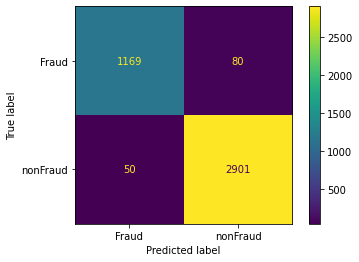

In [116]:
plot_confusion_matrix(clf, X_test, y_test, display_labels=['Fraud', 'nonFraud'], values_format='d')

In [119]:
del X, y, X_train, X_test, y_train, y_test, clf

## 6 Predict Test data

In [120]:
X = train[fs_after]
y = train['FRAUD_NONFRAUD']
clf = lgb.LGBMClassifier(**params2)
clf.fit(X, y)

LGBMClassifier(bagging_fraction=0.7000000000000001, bagging_freq=3,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.4, importance_type='split',
               lambda_l1=0.12162482807633003, lambda_l2=0.009312165250254235,
               learning_rate=0.09755105871568558, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=60, min_split_gain=0.0,
               min_sum_hessian_in_leaf=0.514621871370952, n_estimators=100,
               n_jobs=-1, num_leaves=280, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [121]:
sub = pd.DataFrame()
sub['dataset_id'] = test['dataset_id']
sub['FRAUD_NONFRAUD'] = np.rint(clf.predict_proba(test[fs_after])[:, 1])

In [122]:
sub.to_csv('sub.csv', index=False)
!cp sub.csv "/content/drive/MyDrive/WellsFargo competition/"

In [124]:
sub.head()

,dataset_id,FRAUD_NONFRAUD
0,1,1.0
1,2,1.0
2,3,1.0
3,4,1.0
4,5,1.0


In [126]:
sub['FRAUD_NONFRAUD'].value_counts()

1.0    4203
0.0    1797
Name: FRAUD_NONFRAUD, dtype: int64